# **Autoencoder Training**

Importing packages/modules

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import os
from keras import layers
from tensorflow.keras import datasets, layers, models, losses, Model, regularizers
from tensorflow.keras import Sequential
from keras.layers import Input, Dense, Flatten, Reshape, InputLayer, Conv2D, Conv2DTranspose,GlobalAveragePooling2D
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model

Creating a datagenerator for training and validation data

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2, rescale=1./255)

In [7]:
#training data
train_data = datagen.flow_from_directory('/kaggle/input/flamedb/Test', 
                                       target_size = (256,256),
                                       batch_size=32,
                                       class_mode = 'input',
                                       subset='training')

Found 6894 images belonging to 2 classes.


In [8]:
#validation data
valid_data = datagen.flow_from_directory('/kaggle/input/flamedb/Test',
                                         target_size = (256,256),
                                         batch_size=32,
                                         class_mode = 'input',
                                         subset='validation')

Found 1723 images belonging to 2 classes.


Autoencoder model

In [7]:
#input shape 256x256x3
input_img = Input(shape=(256,256,3))

#encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (16, 16, 32)

#decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     73856     
                                                             

In [11]:
#checkpoint to monitor validation accuracy
checkpoint_filepath = "/kaggle/working/checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [12]:
#Model Training
history = autoencoder.fit(train_data, validation_data=valid_data, epochs=50, callbacks=[checkpoint_callback],shuffle=True)

Epoch 1/50
216/216 [==============================] - 116s 444ms/step - loss: 0.0190 - accuracy: 0.5932 - val_loss: 0.0091 - val_accuracy: 0.6470
Epoch 2/50
216/216 [==============================] - 83s 385ms/step - loss: 0.0088 - accuracy: 0.6811 - val_loss: 0.0072 - val_accuracy: 0.6940
Epoch 3/50
216/216 [==============================] - 81s 375ms/step - loss: 0.0076 - accuracy: 0.7003 - val_loss: 0.0066 - val_accuracy: 0.6969
Epoch 4/50
216/216 [==============================] - 81s 372ms/step - loss: 0.0071 - accuracy: 0.7100 - val_loss: 0.0065 - val_accuracy: 0.7172
Epoch 5/50
216/216 [==============================] - 82s 380ms/step - loss: 0.0069 - accuracy: 0.7191 - val_loss: 0.0063 - val_accuracy: 0.7271
Epoch 6/50
216/216 [==============================] - 81s 372ms/step - loss: 0.0063 - accuracy: 0.7412 - val_loss: 0.0068 - val_accuracy: 0.7439
Epoch 7/50
216/216 [==============================] - 81s 373ms/step - loss: 0.0062 - accuracy: 0.7489 - val_loss: 0.0063 - val_a

In [10]:
#Testing on validation data
_, acc = autoencoder.evaluate(valid_data)
print("Testing accuracy = ", (acc * 100.0), "%")

81/81 [==============================] - 11s 136ms/step - loss: 0.0052 - accuracy: 0.7819
Testing accuracy =  78.19439768791199 %


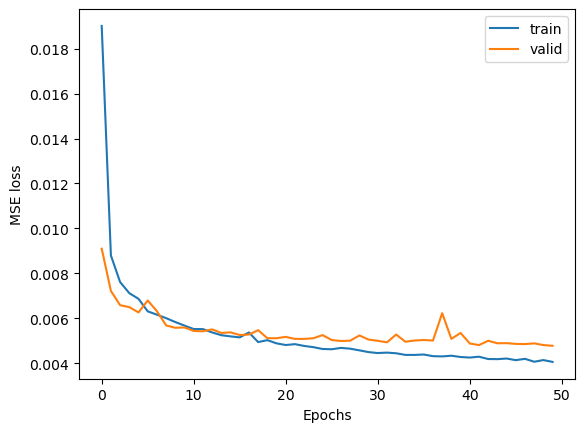

In [13]:
# plot loss curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.ylabel('MSE loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

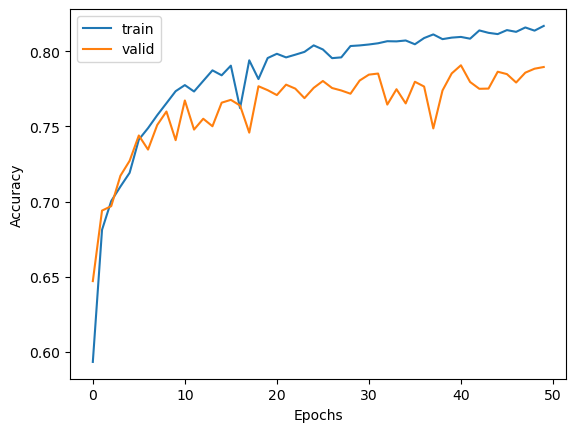

In [14]:
# plotting accuracy curve
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [12]:
#saving autoencoder model
autoencoder.save('/kaggle/working/autoencoder')

**Visualizing reconstruction of input by AE**

In [9]:
images, labels = valid_data.next()

1/1 [==============================] - 0s 379ms/step


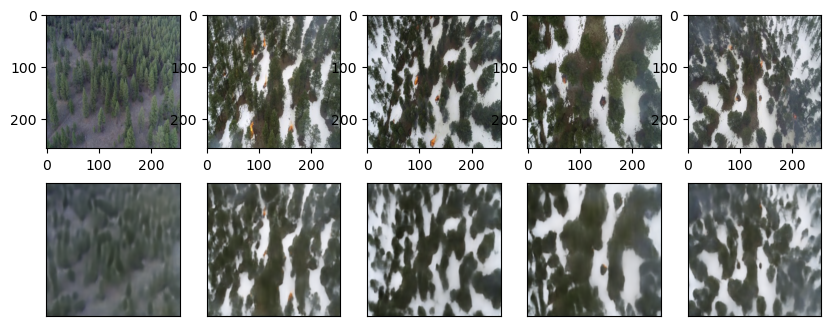

In [10]:
decoded_imgs = autoencoder.predict(images)

n = 5
plt.figure(figsize=(10, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(images[i].reshape(256, 256,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256,256,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Latent space visualization**

1/1 [==============================] - 0s 114ms/step


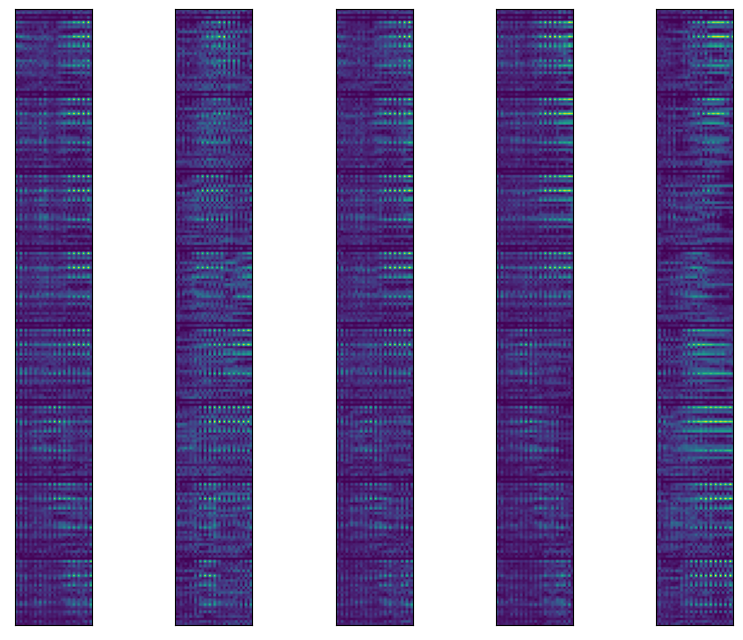

In [31]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(images)

n = 5
plt.figure(figsize=(10, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((32,16*16)).T)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [32]:
#reloading saved autoencoder weights
autoencoder.load_weights('/kaggle/working/checkpoint')

# **Creating classifier using AE**

In [15]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2, rescale=1./255)

In [16]:
train_data1 = datagen.flow_from_directory('/kaggle/input/flamedb/Test', 
                                       target_size = (256,256),
                                       batch_size=32,
                                       class_mode = 'binary',
                                       subset='training')

Found 6894 images belonging to 2 classes.


In [17]:
valid_data1 = datagen.flow_from_directory('/kaggle/input/flamedb/Test',
                                         target_size = (256,256),
                                         batch_size=32,
                                         class_mode = 'binary',
                                         subset='validation')

Found 1723 images belonging to 2 classes.


In [17]:
images, labels = valid_data1.next()

In [18]:
labels

array([1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [19]:
autoencoder.layers[12]

**Classifier model using trained encoder of AE**

In [18]:
classifier=Sequential(name='encoder')
for i in range(0,13):
    classifier.add(autoencoder.layers[i])
classifier.add(Flatten())
classifier.add(Dense(512))
classifier.add(Dense(64))
classifier.add(Dense(1, activation='sigmoid', name='last'))

for layer in classifier.layers[0:-3]:
    layer.trainable = False
    
classifier.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

classifier.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                       

In [83]:
classifier.layers[-3]

In [19]:
#checkpoint to monitor and obtain best validation accuracy
checkpoint_filepath = "/kaggle/working/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [20]:
#model training
history = classifier.fit(train_data1, validation_data=valid_data1, epochs=50, callbacks=[checkpoint_callback],shuffle=True)

Epoch 1/50
216/216 [==============================] - 36s 161ms/step - loss: 0.4620 - accuracy: 0.8377 - val_loss: 0.7268 - val_accuracy: 0.7290
Epoch 2/50
216/216 [==============================] - 32s 146ms/step - loss: 0.0969 - accuracy: 0.9652 - val_loss: 0.8804 - val_accuracy: 0.7673
Epoch 3/50
216/216 [==============================] - 31s 145ms/step - loss: 0.0963 - accuracy: 0.9630 - val_loss: 0.8938 - val_accuracy: 0.7342
Epoch 4/50
216/216 [==============================] - 32s 150ms/step - loss: 0.0509 - accuracy: 0.9811 - val_loss: 1.2669 - val_accuracy: 0.6570
Epoch 5/50
216/216 [==============================] - 32s 149ms/step - loss: 0.0655 - accuracy: 0.9765 - val_loss: 0.5617 - val_accuracy: 0.7974
Epoch 6/50
216/216 [==============================] - 31s 141ms/step - loss: 0.0294 - accuracy: 0.9890 - val_loss: 1.1579 - val_accuracy: 0.7017
Epoch 7/50
216/216 [==============================] - 32s 149ms/step - loss: 0.0440 - accuracy: 0.9852 - val_loss: 1.0578 - val_ac

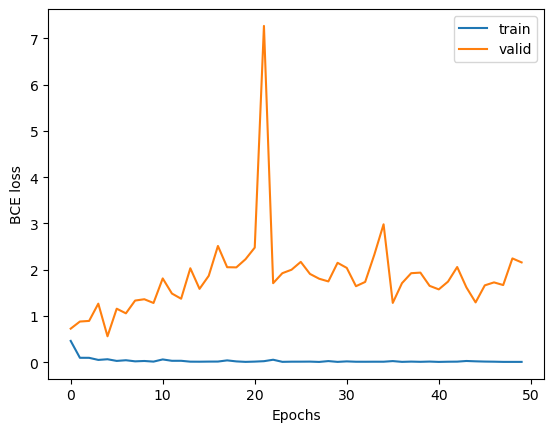

In [21]:
# plot loss curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.ylabel('BCE loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

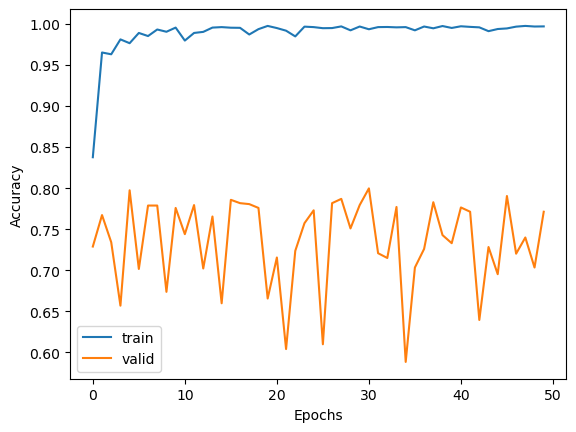

In [22]:
# plot accuracy curve
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [18]:
# model evaluation on validation data
_, acc = classifier.evaluate(valid_data1)
print("Testing accuracy = ", (acc * 100.0), "%")

189/189 [==============================] - 24s 126ms/step - loss: 2.3039 - accuracy: 0.6594
Testing accuracy =  65.94262719154358 %


In [19]:
#obtaining a batch of data from validation data generator
images, labels = valid_data1.next()

Testing on random image

1/1 [==============================] - 0s 22ms/step
The image contains fire 0.00667572021484375
The actual label for this image is:  No_Fire


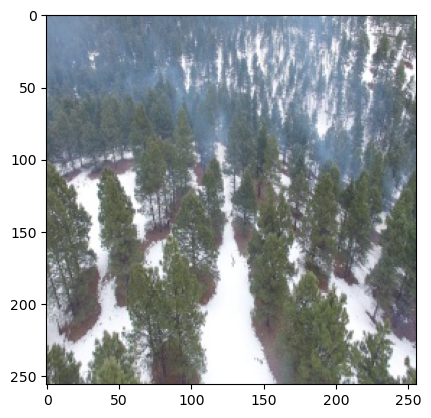

In [21]:
n=17  #Select the index of image to be loaded for testing
img = images[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The image contains fire",(1 - classifier.predict(input_img)[0][0])*100)
print("The actual label for this image is: ", ('Fire' if labels[n]==0 else 'No_Fire'))


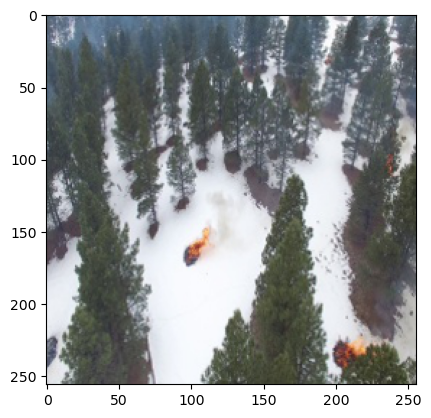

In [124]:
from PIL import Image

img = Image.open('/kaggle/input/flamedb/Test/Fire/resized_test_fire_frame1257.jpg')
img = img.resize((256,256))
img = np.array(img)
plt.imshow(img)

In [125]:
img_tensor = np.expand_dims(img, axis=0)
img_tensor.shape

(1, 256, 256, 3)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.imshow(heat_map, cmap='jet', alpha=0.5)